<a href="https://colab.research.google.com/github/LyumkisLab/SamplingGui/blob/master/WilsonStatistics3D2021General.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Created on Tuesday August  23rd 03:10:00 2021

# author Philip Baldwin, work supported by Salk Institute



#  Check Wilson Statistics 3D


#  Section 0A Imports


In [ ]:
#@title 0A Imports
import scipy.cluster
import os
import numpy as np
#from numba import jit, vectorize, guvectorize, float64, complex64, int32, float32, autojit
from matplotlib import pyplot as plt
from matplotlib import colors
#import mrcfile
import scipy

from sklearn.decomposition import FastICA, PCA, NMF
from mpl_toolkits.mplot3d import Axes3D



In [ ]:
#@title 0A do more Imports
from google.colab import drive
#drive.mount('/content/drive')

import sys
#sys.path.insert(0,'/content/drive/My Drive/ColabNotebooks')

#  Section 0B Define Preliminary Functions

In [ ]:
#@title 0B TakeFFT TakeFFT0 and more subroutines
def TakeFFT(f):
    TwoNplus1= len(f)
    N = (TwoNplus1-1)/2
    K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    KIndex= K+N;
    XIndex = X +N;
    KX = np.outer(K,X)
    KernelR = np.cos(2*np.pi*KX/TwoNplus1)
    KernelI = np.sin(2*np.pi*KX/TwoNplus1)
    FR = np.dot(KernelR,f)
    FI = np.dot(KernelI,f)
    return FR,FI

def TakeFFT0(f):
    TwoNplus1= len(f)
    N = (TwoNplus1-1)/2
    #K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    FComp = scipy.fft.fftshift(scipy.fft.fft(f))
    FPhased =np.conj(FComp)*np.exp(-2*np.pi*X*N*1j/TwoNplus1)
    #KIndex= K+N;
    #XIndex = X +N;
    return FPhased


def TakeIFFT(FR,FI):
    TwoNplus1= len(FR)
    N = (TwoNplus1-1)/2
    K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    KIndex= K+N;
    XIndex = X +N;
    XK = np.outer(X,K)
    KernelR = np.cos(2*np.pi*XK/TwoNplus1)/TwoNplus1
    KernelI = np.sin(2*np.pi*XK/TwoNplus1)/TwoNplus1
    fR = np.dot(KernelR,FR) + np.dot(KernelI,FI)
    fI = np.dot(KernelI,FR) + np.dot(KernelR,FI)
    return fR,fI

def TakeIFFT0(FPhased):
    TwoNplus1= len(FPhased)
    N = (TwoNplus1-1)/2
    #K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    FUnphased = np.conj(FPhased)*np.exp(-2*np.pi*X*N*1j/TwoNplus1)
    #This should be the same as FComp
    fGuessed =np.real(scipy.fft.ifft(scipy.fft.ifftshift(FUnphased)))
    return fGuessed

def Take2DFFT(f2D):
    TwoNplus1= np.shape(f2D)[0]
    N = (TwoNplus1-1)/2
    K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    KIndex= K+N;
    XIndex = X +N;
    XK = np.outer(X,K)
    KernelR = np.cos(2*np.pi*XK/TwoNplus1)/TwoNplus1
    KernelI = np.sin(2*np.pi*XK/TwoNplus1)/TwoNplus1
    fR = np.dot(KernelR,FR) + np.dot(KernelI,FI)
    fI = np.dot(KernelI,FR) + np.dot(KernelR,FI)
    return fR,fI


def Take2DFFT0(fFilteredBoxed):
    TwoNplus1= np.shape(fFilteredBoxed)[0]
    N = (TwoNplus1-1)/2
    K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    Phase0 = np.exp(-2*np.pi*X*N*1j/TwoNplus1)
    PhaseFactor = np.outer(Phase0,Phase0) 

    FComp = scipy.fft.fftshift(scipy.fft.fft2(fFilteredBoxed))
    F =np.conj(FComp)*PhaseFactor; # the FT of input f
    #print(np.shape(FComp),np.shape(PhaseFactor))
    return  F ; # The Fourier Transform of fFilteredBoxed

def Take2DIFFT0(F):
    TwoNplus1= np.shape(F)[0]
    N = (TwoNplus1-1)/2
    K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    Phase0 = np.exp(-2*np.pi*X*N*1j/TwoNplus1)
    PhaseFactor = np.outer(Phase0,Phase0) 

    FUnphased = np.conj(F)*PhaseFactor
    fGuessed =np.real(scipy.fft.ifft2(scipy.fft.ifftshift(FUnphased)))

    return  fGuessed ; # The Fourier Transform of fFilteredBoxed


def Take3DFFT0(fFilteredBoxed):
    TwoNplus1= np.shape(fFilteredBoxed)[0]
    N = (TwoNplus1-1)/2
    K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    Phase0 = np.exp(-2*np.pi*X*N*1j/TwoNplus1)
    PhaseFactor = np.outer(Phase0,Phase0) 
    #print(np.shape(Phase0),np.shape(PhaseFactor))
    PhaseFactor1 = np.outer(PhaseFactor,Phase0) 
    
    #print(np.shape(Phase0),np.shape(PhaseFactor1))

    PhaseFactor = np.reshape( PhaseFactor1,[TwoNplus1,TwoNplus1,TwoNplus1])

    #PhaseFactor = 1;

    FComp = scipy.fft.fftshift(scipy.fft.fftn(fFilteredBoxed))
    F =np.conj(FComp)*PhaseFactor; # the FT of input f
    #print(np.shape(FComp),np.shape(PhaseFactor))

    return  F ; # The Fourier Transform of fFilteredBoxed

def Take3DIFFT0(F):
    TwoNplus1= np.shape(F)[0]
    N = (TwoNplus1-1)/2
    K = np.arange(-N,N+1)
    X = np.arange(-N,N+1)
    Phase0 = np.exp(-2*np.pi*X*N*1j/TwoNplus1)
    PhaseFactor = np.outer(Phase0,Phase0) 
    PhaseFactor1 = np.outer(PhaseFactor,Phase0) 
    PhaseFactor = np.reshape( PhaseFactor1,[TwoNplus1,TwoNplus1,TwoNplus1])

    FUnphased = np.conj(F)*PhaseFactor
    fGuessed =np.real(scipy.fft.ifftn(scipy.fft.ifftshift(FUnphased)))

    return  fGuessed ; # The Fourier Transform of fFilteredBoxed


**The** next section checks the routines, otherwise skip

In [ ]:
#@title Check Subroutines; Hidden
#### Hide cell
if 0:
  f=np.arange(9).reshape([3,3])

  F = Take2DFFT0(f)

  print(np.shape(F))


  f=np.arange(27).reshape([3,3,3])

  f=np.random.rand(101,101,101)

  F = Take3DFFT0(f)

  Fabs = np.abs(F)

  fGuessed = Take3DIFFT0(F)
  plt.figure(figsize=(12,12))
  plt.subplot(1,2,1)
  plt.imshow(f[100,:,:],cmap='gray')
  plt.title(' Original Noisy function of size 101 on edge')

  plt.subplot(1,2,2)
  plt.imshow(fGuessed[100,:,:],cmap='gray')
  plt.title(' IFT(FFT of original))')

  print(f[100,100,100],fGuessed[100,100,100])
  #print(F)
  #plt.title('A slice of the abs of FT of 17x17x17 random matrix')
  #plt.imshow(np.abs(F[2,:,:]),cmap='gray')

if 0:
  print("FT")
  f=np.array([1,2,3,4,5])
  FR,FI=  TakeFFT(f)
  print(FR,FI)

  print("FT the fast way")
  FAll = TakeFFT0(f)
  print(FAll)

  print("Inverse FT ")
  fAfter = TakeIFFT(FR,FI)
  print(fAfter)

  print("Inverse FT the fast way")
  fAfter = TakeIFFT0(FAll)
  print(fAfter)

  print(" Beginning 2D f ")
  f=array = np.arange(9).reshape(3,3)
  print(f)

  print("2D FT ")
  F = Take2DFFT0(f)
  print(F)

  print("inverse of 2D FT ")
  fGuessed = Take2DIFFT0(F)
  print(fGuessed)

  plt.imshow(np.abs(F[0,:,:]))

  if 0:
    FComp = scipy.fft.fftshift(scipy.fft.fft(f))
    FPhased =np.conj(FComp)*np.exp(-2*np.pi*X*N*1j/TwoNplus1)
  #FR[N+1]
  #Out[22]: 0.5021741235382479

  #print(FPhased[N-1])
  #print(FR[N-1],FI[N-1])
  #ArgsDesired= (np.arctan2(FI,FR))
  #ArgsDirect = (np.angle(FComp))



In [ ]:
#@title New Programs    GetValuesAtRad(ImageWithOriginInCenter, Radius),  <br> GetIFibDirections_Kernel(deltaTheta),   <br> CoarseGrainDataOnSphere(nVecFR7,ValVec,nVecT)


def GetValuesAtRad3D(ImageWithOriginInCenter, Radius):
  ShapeNow = np.shape(ImageWithOriginInCenter)
  IndValueAtCenter= ShapeNow[0]//2;
  IndMax = IndValueAtCenter
  Dimension= len(ShapeNow)
  #CircAvNow  = np.zeros(IndMax)
  #CircSumNow = np.zeros(IndMax)
  #WeightsNow = np.zeros(IndMax)

  ValNowVec=[]
  ThetaVec =[]
  PhiVec =[]
  Count=0
  RadiusSq = Radius*Radius
  jMax = np.min([Radius,IndMax])
  for jx in range(-jMax,jMax+1):
    DistNowSqX = jx*jx
    DistNow = np.sqrt(DistNowSqX)
    #if np.abs(DistNow-Radius)>1:continue
    for jy in range(-jMax,jMax+1):
      DistNowSqY = DistNowSqX + jy*jy
      DistNow = np.sqrt(DistNowSqY)
      #if np.abs( DistNow -Radius)>1:continue
      for jz in range(-jMax,jMax+1):
        #print(jx,jy,jz)
        DistNowSq = DistNowSqY +jz*jz
        DistNow = np.sqrt(DistNowSq)
        #print(jx,jy,jz,DistNow,Radius)
        if np.abs(DistNow-Radius)>=0.51:continue
        PhiNow = np.arctan2(jy,jx)
        ThetaNow = np.arccos(jz/DistNow)
        jxActual = jx+IndMax
        jyActual = jy+IndMax
        jzActual = jz+IndMax
        ValNow =  ImageWithOriginInCenter[jxActual,jyActual,jzActual]
        DistLo= np.int(DistNow)
        DistHi= DistLo+1;
        if (DistLo==Radius) or (DistHi==Radius):
          WeightLo =  DistHi-DistNow
          WeightHi =  DistNow - DistLo
          #if DistLo >= IndMax: continue
          #CircSumNow[DistLo] += WeightLo*ValNow
          #WeightsNow[DistLo] += WeightLo
          #if DistHi >= IndMax: continue
          #CircSumNow[DistHi] += WeightHi*ValNow
          #WeightsNow[DistHi] += WeightHi
          ValNowVec.append(ValNow)
          ThetaVec.append(ThetaNow)
          PhiVec.append(PhiNow)


  #CircAvNow = CircSumNow/WeightsNow
  PhiVec= np.array(PhiVec)*180/np.pi
  ThetaVec= np.array(ThetaVec)*180/np.pi
  ValNowVec= np.array(ValNowVec)

  return ThetaVec, PhiVec, ValNowVec

def CircAverage(ImageWithOriginInCenter): # defunct
  ShapeNow = np.shape(ImageWithOriginInCenter)
  IndValueAtCenter= ShapeNow[0]//2;
  IndMax = IndValueAtCenter
  Dimension= len(ShapeNow)
  CircAvNow  = np.zeros(IndMax)
  CircSumNow = np.zeros(IndMax)
  WeightsNow = np.zeros(IndMax)

  for jx in range(-IndMax,IndMax+1):
    for jy in range(-IndMax,IndMax+1):
      for jz in range(-IndMax,IndMax+1):
        jxActual = jx+IndMax
        jyActual = jy+IndMax
        jzActual = jz+IndMax

        ValNow =  ImageWithOriginInCenter[jxActual,jyActual,jzActual]
        DistNow = np.sqrt(jx*jx+jy*jy+jz*jz)
        DistLo= np.int(DistNow)
        DistHi= DistLo+1;
        WeightLo =  DistHi-DistNow
        WeightHi =  DistNow - DistLo
        if DistLo >= IndMax: continue
        CircSumNow[DistLo] += WeightLo*ValNow
        WeightsNow[DistLo] += WeightLo
        if DistHi >= IndMax: continue
        CircSumNow[DistHi] += WeightHi*ValNow
        WeightsNow[DistHi] += WeightHi

  CircAvNow = CircSumNow/WeightsNow

  return CircAvNow,WeightsNow


def GetIFibDirections_Kernel(deltaTheta):
    #deltaTheta = float(argv[1]); 
    deltaThetaRad=np.pi*deltaTheta/180.0;
    #Directions_csv_out = argv[2];
    
    # Now, deltaTheta takes up a cone which has area
    #    2 pi * (1-cos(deltaTheta))
    # The surface area of the Sphere is 4 pi
    # We need Hemisphere (as opposed to sphere) because the 
    #   unit vectors take up both directions
    #  So the fraction for each plaquette is (1- cos(theta))
    # N should be about 1 over this fraction.
    # But we will create twice so many.
    
    
    #  Section 1. Calculate location of points
    #
    FractionOfHemi = 1- np.cos(deltaThetaRad);
    NumPoints = int(round(2.0/FractionOfHemi));
    # 
    NumPoints = (NumPoints//2)*2+1
    NPos= (NumPoints-1)//2
    
    phi=(1.0+ np.sqrt(5.0))/2.0-1
    ga = phi*2.0*np.pi;#  The Golden Angle
    
    
    nVec=np.zeros([NumPoints,3]);
    jLongitude=np.arange(-NPos,NPos+1);
    
    longitude = ga*jLongitude;
    latitude  =  np.arcsin(1.0*jLongitude/NPos);# for hemisphere
    nhatz = np.sin(latitude);
    nhatx = np.cos(latitude)*np.cos(longitude);
    nhaty = np.cos(latitude)*np.sin(longitude);

    nVec = np.concatenate([nhatx,nhaty,nhatz])
    nVec = np.reshape(nVec,[3,NumPoints])

#    
#    
#    for jLongitude  in range(NumPoints):
#    	longitude = ga*jLongitude;
#    	#latitude  = asin(-1.0+2.0*jLongitude/NumPoints); for sphere
#    	latitude  = np.arcsin(1.0*jLongitude/NumPoints);# for hemisphere
#    	nhatz = np.sin(latitude);
#    	nhatx = np.cos(latitude)*cos(longitude);
#    	nhaty = np.cos(latitude)*sin(longitude);
#    	nNow = np.array([nhatx,nhaty,nhatz]);
#    	nVec.append(nNow);
#    
    

    return nVec.T
    
    


def CoarseGrainDataOnSphere(nVecFR7,ValVec,nVecT):
  #find Fibonacci spiral consistent with ThetaCone
  NumVals = np.shape(nVecFR7)[0]
  NumGrid = np.shape(ValVec)[0]

  ValsSum = np.zeros(NumGrid)
  Weights = np.zeros(NumGrid)

  for Count,ValNow in enumerate(ValVec):
     nVecFR7Now  = ValNowVec[Count]
     ThetaNow= ThetaInVec[Count]
     PhiNow= PhiInVec[Count]
     nVecFineNow
     ThetaUpper = np.int(ThetaNow+ThetaCone)
     ThetaLower = np.int(ThetaNow-ThetaCone)
     #print(ThetaLower,ThetaUpper)
     if (ThetaLower >=0) & (ThetaUpper<360):
        ValsSum[ThetaLower:ThetaUpper] += ValNow
        Weights[ThetaLower:ThetaUpper] += 1
     if (ThetaLower <0) and (ThetaUpper<360):
        ValsSum[:ThetaUpper] += ValNow
        Weights[:ThetaUpper] += 1
        ValsSum[ThetaLower:] += ValNow
        Weights[ThetaLower:] += 1
     if (ThetaLower >0) and (ThetaUpper>=360):
        ValsSum[ThetaLower:] += ValNow
        Weights[ThetaLower:] += 1
        ValsSum[:(ThetaUpper-360)] += ValNow
        Weights[:(ThetaUpper-360)] += 1

  return ValsSum/Weights,Weights



In [ ]:
#@title Legacy code (skip)) Fib Directions
if 0:
    deltaTheta=20
    deltaThetaRad=np.pi*deltaTheta/180.0;
    #Directions_csv_out = argv[2];
    
    # Now, deltaTheta takes up a cone which has area
    #    2 pi * (1-cos(deltaTheta))
    # The surface area of the Sphere is 4 pi
    # We need Hemisphere (as opposed to sphere) because the 
    #   unit vectors take up both directions
    #  So the fraction for each plaquette is (1- cos(theta))
    # N should be about 1 over this fraction.
    # But we will create twice so many.
    
    
    #  Section 1. Calculate location of points
    #
    FractionOfHemi = 1- np.cos(deltaThetaRad);
    NumPoints = int(round(2.0/FractionOfHemi));
    # 
    NumPoints = (NumPoints//2)*2+1
    NPos= (NumPoints-1)//2
    
    phi=(1.0+ np.sqrt(5.0))/2.0-1
    ga = phi*2.0*np.pi;#  The Golden Angle
    
    
    nVec=np.zeros([NumPoints,3]);
    jLongitude=np.arange(-NPos,NPos+1);
    
    longitude = ga*jLongitude;
    latitude  =  np.arcsin(1.0*jLongitude/NPos);# for hemisphere
    nhatz = np.sin(latitude);
    nhatx = np.cos(latitude)*np.cos(longitude);
    nhaty = np.cos(latitude)*np.sin(longitude);

    nVec = np.concatenate([nhatx,nhaty,nhatz])
    nVec = np.reshape(nVec,[3,NumPoints])

    print(np.shape(nVec),NumPoints)
    print(np.shape(nhatx),np.shape(jLongitude))


In [ ]:
#@title Execute this
# Get Fibonnaci directions store for 20 degrees in nVecT, snVecT

deltaTheta= 20; 
nVecT = GetIFibDirections_Kernel(deltaTheta)
snVecT = len(nVecT)
# This number should be smaller than 4 pi k^2. 
# Later we use k=7;
# 4 k^2 aoub 200, so this should be about 600, actual is 33 (for deltaTheta =20). 
# We want to put this data to the 33 points given by nVecT.

if 0:
  print(np.shape(nVecT))

  plt.figure(figsize=(8,4))
  plt.subplot(1,2,1)
  plt.title('Fib ' + str(snVecT)+ ' Sampling Points on Sphere')
  plt.scatter(nVecT[:,0],nVecT[:,1])
  plt.subplot(1,2,2)
  plt.hist(nVecT[:,0])
  plt.title('hist of x vals; delta Theta=10')


In [ ]:
#@title Some Testing; Can skip
if 0:
  #fGuessed = Take3DIFFT0(F)
  #print(fGuessed) 
  FourierRadius =50

  ThetaVec, PhiVec, ValVec= GetValuesAtRad3D(F,FourierRadius)

  nVec7X = np.sin(ThetaVec*np.pi/180.0)*np.cos(PhiVec*np.pi/180.0)
  nVec7Y = np.sin(ThetaVec*np.pi/180.0)*np.sin(PhiVec*np.pi/180.0)
  nVec7Z = np.cos(ThetaVec*np.pi/180.0)
  nVec7 = np.vstack([nVec7X,nVec7Y,nVec7Z]).T
  #nVecZ = np.cos(ThetaVec)
  At1 = ValVec
  print(len(At1))
  #print(At1)
  #print(Fabs)

  # nVecFR7,ValVec,nVecT

  nVecFRFinebynVecCoarse = np.dot(nVec7,nVecT.T)
  #plt.figure(figsize=(5,40))
  #plt.imshow(nVecFRFinebynVecCoarse,cmap='gray')
  print(np.shape(nVecFRFinebynVecCoarse)); # 602 by 33
  # For each row, find


In [ ]:
#@title (skipped) Conically Ave  Power for some Random Points

if 0:
  #AA= np.max(nVecFRFinebynVecCoarse,axis=1);
  #print(len(AA))

  IndsMax = np.argmax(nVecFRFinebynVecCoarse, axis=1)

  #print(len(AA),AA[0],nVecFRFinebynVecCoarse[0,IndsMax[0]])

  NumIn  = np.shape(nVecFRFinebynVecCoarse)[0]
  NumOut = np.shape(nVecFRFinebynVecCoarse)[1]
  ValSumOut = np.zeros(NumOut,dtype=complex);
  Val2SumOut = np.zeros(NumOut);
  WeightOut = np.zeros(NumOut);
  # = len(np.where(IndsMax==jNow)[0])
  for jNow in range(NumIn):
    IndNow = IndsMax[jNow]
    ValNow = ValVec[jNow]
    Val2Now = np.abs(ValNow)*np.abs(ValNow)
    WeightOut[IndNow] +=1
    ValSumOut[IndNow] += ValNow
    Val2SumOut[IndNow] += Val2Now

  if 0: plt.plot(WeightOut,'.')

  ValsConicallyAveraged =   ValSumOut/WeightOut
  Vals2ConicallyAveraged =   Val2SumOut/WeightOut

  plt.figure(figsize=(14,4))
  plt.subplot(1,3,1)
  plt.hist(Vals2ConicallyAveraged/10000)
  plt.xlim(0,10)
  plt.title('Conically Ave Power for Random Points; FR=50')
  plt.subplot(1,3,2)
  plt.hist(WeightOut)
  plt.title('hist Weights for 33 points; dTheta=20')
  plt.xlim(0,1200)
  plt.subplot(1,3,3)
  plt.title('Weights for 33 points; dTheta=20')

  plt.plot(WeightOut,'.')
  #ValSumOut

In [ ]:
#@title look at stats of 32,498 points at FR=50 <br> btw $4/3 \, \pi r^3$ is 31, 415 which is close <br> (skip)
# Combine nVec7 which was discrete info gathered at the FR=7
# and put the data to the smaller grid given by nVec 

#ValsAveraged,Weights =  CoarseGrainDataOnSphere(nVec7,ValVec,nVecT)
if 0:
  nVec7 = np.vstack([nVec7X,nVec7Y,nVec7Z]).T
  print(np.shape(nVec7X),np.shape(nVec7),nVec7X[1],nVec7[1,0])

  plt.title('check distribution')
  plt.hist(nVec7[:,2])

  plt.subplot(1,2,1)
  plt.scatter(ThetaVec,PhiVec)
  plt.title('Scatter Plot Phi vs Theta')
  plt.subplot(1,2,2)
  plt.hist(ThetaVec)
  plt.title('Hist Theta: FR = 50')

In [ ]:
#@title  (not necessary)
#To check anisotropy we want to grid large number of values at a given Fourier Radius to a grid of 33 sampling values representing 20 degree cone

In [ ]:
#@title (not necessary)
#This is code for doing the rotational average of point atoms as function of FR

if 0:
  FourierRadius =50
  RotAveragedPowerSpectrum = np.zeros(40)

  for FourierRadiusNow in range(1,20):
    ThetaVec, PhiVec, ValVec= GetValuesAtRad3D(F,FourierRadiusNow)
    F2Now = np.abs(ValVec)* np.abs(ValVec)
    RotAveragedPowerSpectrum[FourierRadiusNow] = np.mean(F2Now)

  plt.plot(RotAveragedPowerSpectrum,'.')


In [ ]:
#@title All Routines have been tested, start creating actual signal.


In [ ]:
#@title Create Signal With 12001 peaks width 1 on [-50,50] with <br>   total interval  [-200,200] with 1001 points. <br> XMax, X, Y, Z, NumPoints, NBar, NumPeaks (12001) created

RandSeedNum=0
np.random.seed(RandSeedNum)
XMax=200; #First was 400, which worked great July 4th 2021
NumPoints=2*(XMax)+1
NumPeaks =12001
IntervalOfPeaksMax= 50



#N=10*(2*L) +1
NBar =(NumPoints-1)//2

X = np.linspace(-XMax,XMax,NumPoints)
Y = np.linspace(-XMax,XMax,NumPoints)
Z = np.linspace(-XMax,XMax,NumPoints)

print('XMax,NumPoints,NumPeaks,IntervalOfPeaksMax=R')
print(XMax,NumPoints,NumPeaks,IntervalOfPeaksMax)






XMax,NumPoints,NumPeaks,IntervalOfPeaksMax=R
200 401 12001 50


In [ ]:
#@title Mesh the values to Xv, Yv, Zv

#Xv, Yv = np.meshgrid(X, Y, sparse=False) 

Xv, Yv, Zv = np.meshgrid(X,Y,Z) 

#Z = np.linspace(-XMax,XMax,NumPoints)
XInt = np.arange(-NBar,NBar+1); # for Use in plotting FT
YInt = np.arange(-NBar,NBar+1); # for Use in plotting FT

OnesX = np.ones_like(X);
OnesY = np.ones_like(X);


In [ ]:
#@title  Create the 12001 PosPeaks, make sure they are within sphere. This yields 6304 "atoms".
np.random.seed(0)


PosPeaksX = (2*IntervalOfPeaksMax*(np.random.rand(NumPeaks)-.5))
PosPeaksY = (2*IntervalOfPeaksMax*(np.random.rand(NumPeaks)-.5))
PosPeaksZ = (2*IntervalOfPeaksMax*(np.random.rand(NumPeaks)-.5))


PosPeaksR = np.sqrt(PosPeaksX*PosPeaksX+ PosPeaksY*PosPeaksY + PosPeaksZ*PosPeaksZ )
GoodInds = np.where(PosPeaksR < IntervalOfPeaksMax)[0]
#PosPeaksTheta = np.arctan2(PosPeaksY,PosPeaksX)


PosPeaks = np.vstack((PosPeaksX[GoodInds], PosPeaksY[GoodInds], PosPeaksZ[GoodInds])).T



NumFinalPeaks= np.shape(PosPeaks)[0]

print('The Final Number of peaks is NumFinalPeaks='+str(NumFinalPeaks))

The Final Number of peaks is NumFinalPeaks=6304


In [ ]:
#@title Put PosPeaks to the lattice sites into f, so that there is no interpolation
 # Don't do it the original way. Define lattice sites 
f=np.zeros_like(Xv)

if 0:
  for CountPeak, jPeakv in enumerate(PosPeaks[:20,:]):
    temp =  np.power(Xv-jPeakv[0],2) +np.power(Yv-jPeakv[1],2) +np.power(Zv-jPeakv[1],2) 
    envelopeNow = np.exp(-temp/2/sigma2)
    f +=envelopeNow
    
for CountPeak, jPeakv in enumerate(PosPeaks):
  XNow = jPeakv[0]; YNow = jPeakv[1]; ZNow = jPeakv[2];
  XInt = int(round(XNow))+XMax;   YInt = int(round(YNow))+XMax;   ZInt = int(round(ZNow))+XMax;
  f[XInt,YInt,ZInt] +=1





206 153 199 50 2.0


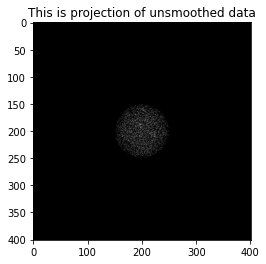

In [ ]:
#@title plt.imshow(np.sum(f,axis=0),cmap='gray')

plt.imshow(np.sum(f,axis=0),cmap='gray')
plt.title('This is projection of unsmoothed data')
print(XInt,YInt,ZInt,IntervalOfPeaksMax,np.max(f))

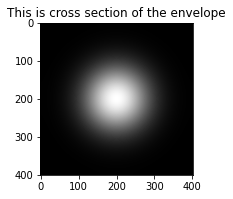

In [ ]:
#@title Set up filter (FFTenvelope0) to multiply by FFT(f). This is equivalent to giving the atoms an atomic form factor.

sigma = 1.1;
sigma2 = sigma*sigma;

Arg0= Xv*Xv+Yv*Yv+Zv*Zv
envelope0 =  np.exp(-Arg0/2/sigma2)
FFTenvelope0 = np.real(Take3DFFT0(envelope0))

plt.subplot(1,2,1)
plt.title('This is cross section of the envelope')
plt.imshow(FFTenvelope0[200,:,:],cmap=plt.cm.gray)

Factor0 = np.max(FFTenvelope0)
FFTenvelope0= FFTenvelope0/Factor0
FFTenvelopeAbs = np.abs(FFTenvelope0)
FFTenvelope2 = FFTenvelopeAbs*FFTenvelopeAbs
if 0:
  plt.subplot(1,2,2)
  plt.semilogy(X,FFTenvelope0[501,:])

  plt.plot(FFTenvelope0)



In [ ]:
#@title  Apply FFTenvelope 0 to FWithout to get FFull, fFull

FWithout = Take3DFFT0(f);
FFull = FFTenvelope0*FWithout
fFull = Take3DIFFT0(FFull)

(401, 401, 401)


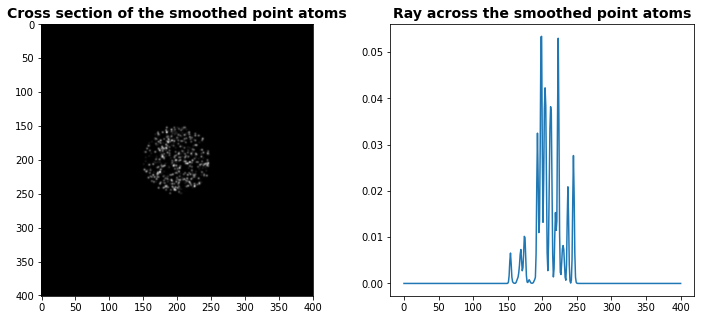

In [ ]:
#@title  Cross section, ray of the smoothed point atoms

print(np.shape(FFull))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Cross section of the smoothed point atoms',fontsize=14,fontweight='bold')
plt.imshow(np.abs(fFull[201,:,:]),cmap='gray')
plt.subplot(1,2,2)
plt.title('Ray across the smoothed point atoms',fontsize=14,fontweight='bold')
plt.plot(fFull[201,201,:])


In [ ]:
print(np.shape(PosPeaks),np.shape(Xv),np.shape(Yv),np.shape(Zv))

(6304, 3) (401, 401, 401) (401, 401, 401) (401, 401, 401)


Text(0.5, 1.0, 'Hist of z comp of peaks ')

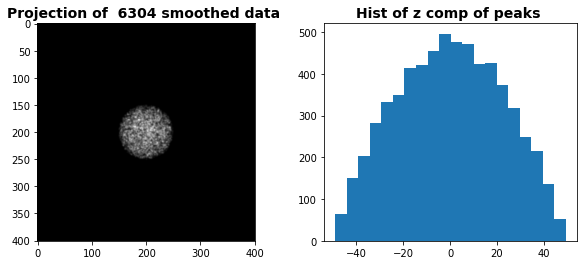

In [ ]:
#@title  Projection of the smoothed point atoms, histogram of z values

fProjected = np.sum(fFull,axis=2)

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.imshow(fProjected,cmap=plt.cm.gray)
plt.title('Projection of  6304 smoothed data ',fontsize=14,fontweight='bold')

plt.subplot(1,2,2)
plt.hist(PosPeaks[:,2],20)
plt.title('Hist of z comp of peaks ',fontsize=14,fontweight='bold')

In [ ]:
#@title Get values of FFull at FR=50 <br> Create nVecFRFinebynVecCoarse which we will use to do interpolation; it is how close the actually measured data is to the grid of 33 points, which represents the sample points of the 20 degree conically averaged points
#fGuessed = Take3DIFFT0(F)
#print(fGuessed) 
FourierRadius =50

ThetaVec, PhiVec, ValVec= GetValuesAtRad3D(FFull,FourierRadius)

nVec7X = np.sin(ThetaVec*np.pi/180.0)*np.cos(PhiVec*np.pi/180.0)
nVec7Y = np.sin(ThetaVec*np.pi/180.0)*np.sin(PhiVec*np.pi/180.0)
nVec7Z = np.cos(ThetaVec*np.pi/180.0)
nVec7 = np.vstack([nVec7X,nVec7Y,nVec7Z]).T
#nVecZ = np.cos(ThetaVec)
At1 = ValVec
print(len(At1))
#print(At1)
#print(Fabs)

# nVecFR7,ValVec,nVecT

nVecFRFinebynVecCoarse = np.dot(nVec7,nVecT.T)
#plt.figure(figsize=(5,40))
#plt.imshow(nVecFRFinebynVecCoarse,cmap='gray')
print(np.shape(nVecFRFinebynVecCoarse)); # 602 by 33



32498
(32498, 33)


In [ ]:
#@title (skip) 
#Find Conical Average for FR=50
# For each row, find
if 0:
  IndsMax = np.argmax(nVecFRFinebynVecCoarse, axis=1)
  NumIn  = np.shape(nVecFRFinebynVecCoarse)[0]
  NumOut = np.shape(nVecFRFinebynVecCoarse)[1]
  ValSumOut = np.zeros(NumOut,dtype=complex);
  Val2SumOut = np.zeros(NumOut);
  WeightOut = np.zeros(NumOut);
  # = len(np.where(IndsMax==jNow)[0])
  for jNow in range(NumIn):
    IndNow = IndsMax[jNow]
    ValNow = ValVec[jNow]
    Val2Now = np.abs(ValNow)*np.abs(ValNow)
    WeightOut[IndNow] +=1
    ValSumOut[IndNow] += ValNow
    Val2SumOut[IndNow] += (Val2Now)

  if 0: plt.plot(WeightOut,'.')

  ValsConicallyAveraged =   ValSumOut/WeightOut
  Vals2ConicallyAveraged =   Val2SumOut/WeightOut

  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.hist(Vals2ConicallyAveraged/1000)
  plt.xlim(0,5)
  plt.title('Conically Ave  Power; FR=50',fontsize=14,fontweight='bold')
  plt.subplot(1,2,2)
  plt.hist(WeightOut)
  plt.title('Weights for 33 points; dTheta=20',fontsize=14,fontweight='bold')
  plt.xlim(0,1200)
  #ValS

In [ ]:
#@title skip
#print(jNow,IndNow,nVecFRFinebynVecCoarse[jNow,IndNow])

In [ ]:
#@title skip
if 0:
  plt.figure(figsize=[20,6])
  #plt.imshow(nVecFRFinebynVecCoarse[-400:,:])
  plt.plot(nVecFRFinebynVecCoarse[:2000,25],'.')

In [ ]:
#@title skip
if 0:
  plt.hist(np.abs(ValVec))
  print('NumIn at FR =50, NumOut which is 33')
  print(NumIn,NumOut,ValNow)

In [ ]:
#@title Calculate RotAveragedPowerSpectrum as function of Fourier Radius
FourierRadiusMax =50
RotAveragedPowerSpectrum = np.zeros(FourierRadiusMax)

RotAveragedPowerSpectrum[0]= np.max(FFull)*np.max(FFull)

for FourierRadiusNow in range(1,FourierRadiusMax):
  #print(FourierRadiusNow)
  ThetaVec, PhiVec, ValVec= GetValuesAtRad3D(FFull,FourierRadiusNow)
  F2Now = np.abs(ValVec)* np.abs(ValVec)
  RotAveragedPowerSpectrum[FourierRadiusNow] = np.mean(F2Now)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """


Text(0.5, 1.0, 'Rotationally Averaged Power Spectrum atoms in Sphere')

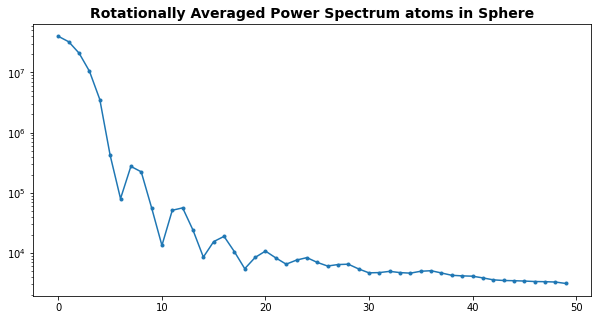

In [ ]:
#@title Plot the Rotationally Averaged Power Spectrum
plt.figure(figsize=[10,5])
plt.semilogy(RotAveragedPowerSpectrum,'.-')
plt.title('Rotationally Averaged Power Spectrum atoms in Sphere',fontsize=14,fontweight='bold')


(50,) (50,)


Text(0.5, 1.0, 'Rotationally Averaged Power Spectrum/Form Factor^2')

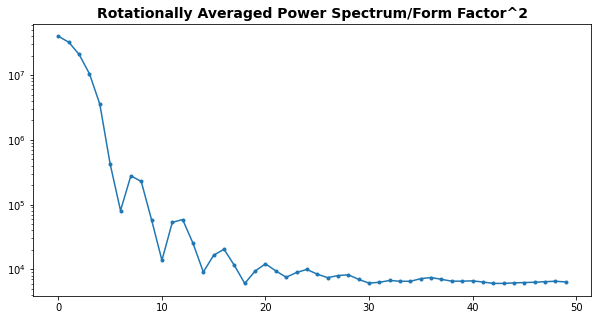

In [ ]:
#@title Plot the Rotationally Averaged Power Spectrum divided by Form Factor^2

FFTenvelope0Sq=  FFTenvelope0*FFTenvelope0
print(np.shape(RotAveragedPowerSpectrum), np.shape(FFTenvelope0Sq[200,200,200:250]))
vv= RotAveragedPowerSpectrum/FFTenvelope0Sq[200,200,200:250]
plt.figure(figsize=[10,5])
plt.semilogy(vv,'.-')
plt.title('Rotationally Averaged Power Spectrum/Form Factor^2',fontsize=14,fontweight='bold')


In [ ]:
#@title Create Factor
if 1:
  print(IntervalOfPeaksMax,XMax)
  FudgeFactor = 2*np.pi*50/401
  print('FudgeFactor, 1/FudgeFactor')
  print(FudgeFactor, 1/FudgeFactor)

50 200
FudgeFactor, 1/FudgeFactor
0.7834395644862328 1.2764226435970005


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'fit for Power Spectrum is n + n(n-1)*|FContainer|^2')

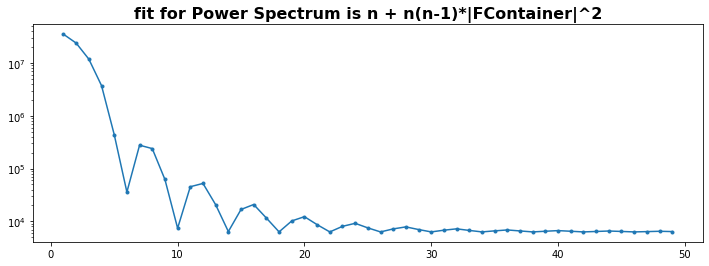

In [ ]:
#@title Create the fit function for power spectrum (Wilson)

# Create a fit function according to Wilson idea

kVec = np.arange(50)

# FofkNormalized is normalized to 1 as k -> 0
kR = XInt*IntervalOfPeaksMax/XMax
kR = kVec*FudgeFactor
FofkNormalized =3* (np.sin(kR)-kR * np.cos(kR))/(kR*kR*kR)

Fit = NumFinalPeaks + NumFinalPeaks*(NumFinalPeaks-1)*FofkNormalized*FofkNormalized;

plt.figure(figsize=(12,4))
plt.semilogy(Fit,'.-')
plt.title('fit for Power Spectrum is n + n(n-1)*|FContainer|^2', fontweight='bold', fontsize=16)


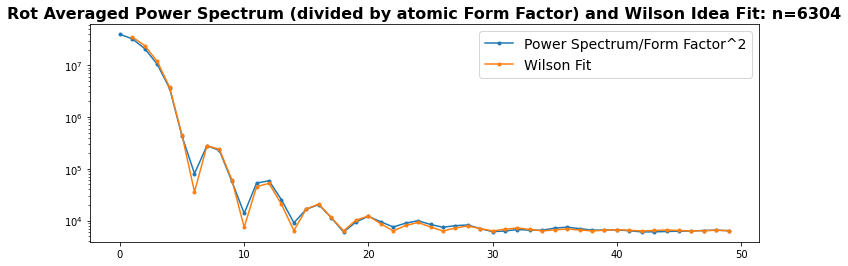

In [ ]:
#@title Plot Normalized Power Spectrum  and Wilson Idea Fit

plt.figure(figsize=(12,4))
plt.semilogy(vv,'.-')
plt.semilogy(Fit,'.-')

plt.title('Rot Averaged Power Spectrum (divided by atomic Form Factor) and Wilson Idea Fit: n=6304', fontweight='bold', fontsize=16)
plt.legend(['Power Spectrum/Form Factor^2','Wilson Fit'],fontsize=14)

## The Theoretical Fit for the normalized power spectrum works extremely well. <br> It  interpolates from low freq behavior (number of atoms^2) to high frequency behavior, <br> which is a constant proportional to the number of atoms. <br> There is a "ringing" due to the hard edge of the container (which is a sphere).